# Capstone - Predicting Titanic Passenger Survival

# Section 1: Introduction
This project will attempt to predict the wether or not a passenger survived the sinking of The Titanic. I discovered this machine learning project while browsing the competitions on https://www.kaggle.com/. 

My goal is to win this competition, using the skills I have learned throughout the Elite Data Science Machine Learning Accelerator course!

### Dataset information
The dataset consists of 891 obervations, 10 features and 1 target variable. It contains a mixture of data types. Each observation refers to a unique passenger.
The data dictionary can be found here https://www.kaggle.com/c/titanic/data

### Acknowledgements
https://www.kaggle.com/c/titanic/overview

### Project findings
The winning model is a gradient boosting classifier with an AUROC score 0.874. Some data cleansing and the engineering of several new features is required to produce the analytical base table. This table is then the base from which to train and test with a hyperparameter grid. 

### Machine learning problem
Predicting the survival of a passenger is a classification problem. This project compares different classification algorithims, and identifies the best performing algorithm for this dataset.

### About me
As a data enthusiast, there was no formal computer science, mathematics, or statistics education for me. However, I value continuous learning and I hope that this machine learning project will showcase much of what I have learned through the Elite Data Science Machine Learning Accelerator course. 


# Section 2: Library Imports

In [45]:
# NumPy for computation
import numpy as np

# Pandas for dataframes
import pandas as pd

# matplotlib for visualization config
from matplotlib import pyplot as plt
%matplotlib inline

# seaborn for easy visualization
import seaborn as sns
sns.set_style('darkgrid')

# scaler to scale numerical features
from sklearn.preprocessing import StandardScaler

# ensemble algos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# train test split, grid search for hyperparameter sweep
from sklearn.model_selection import train_test_split, GridSearchCV

# pipeline
from sklearn.pipeline import make_pipeline

# Pickle for reading model files
import pickle

# Section 3: Exploratory Analysis

Basic Information
* 891 observations, 11 features (including target, excluding index)
* Each feature seems intutive as per data dictionary
* Missing values in Cabin, Age and Embarked features
* features are read in as the correct data type

Distributions

* Sparse data in Ticket, Cabin features needs to be addressed
* summary statistics indicate duplicates in Ticket feature
* distributions are somewhat intuitive, however
    * Outliers in Fare feature, cannot be proven guilty
    * Strange distribution in Age feature amongst low values

Feature Relationships (Segmentations & Correlations)
* categorical features have been segmented and plotted against the target variable to compare distributions
* There are no strong correlations between input features and the target variable
    * this can be seen from the correlation matrix
* Pclass and Fare are logically correlated
    * this can be seen from the correlation matrix
* Some new features to be engineered
    * has_travel_partner
    * has_husband
    * has_cabin
    
Findings
* A higher class of passenger (by Pclass, Fare or Cabin) has is more likely to survive than a lower class.
* Women and children (especially babies) more likely to survive ("womwn and children first")
* Many families onboard and more likely too survive (are they heling each other? or perhaps single travellers are sarificing themselves?)
* Couples sharing same ticket or cabin more likely to survive

In [46]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [48]:
df.PassengerId.nunique()

891

In [49]:
df.duplicated().sum()

0

In [50]:
df = pd.read_csv('train.csv', index_col='PassengerId')
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
df.Cabin.fillna('Missing', inplace=True)
df.Embarked.fillna('Missing', inplace=True)

In [52]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,148,4
top,"McCoy, Mr. Bernard",male,1601,Missing,S
freq,1,577,7,687,644


In [53]:
df.Age.fillna(0, inplace=True)
df['age_missing'] = (df.Age == 0).astype(int)

In [54]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,age_missing
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,23.799293,0.523008,0.381594,32.204208,0.198653
std,0.486592,0.836071,17.596074,1.102743,0.806057,49.693429,0.399210
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,6.000000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


### Distributions of numerical features

Distributions show further investigation of Age and Fare (continuous scale) required

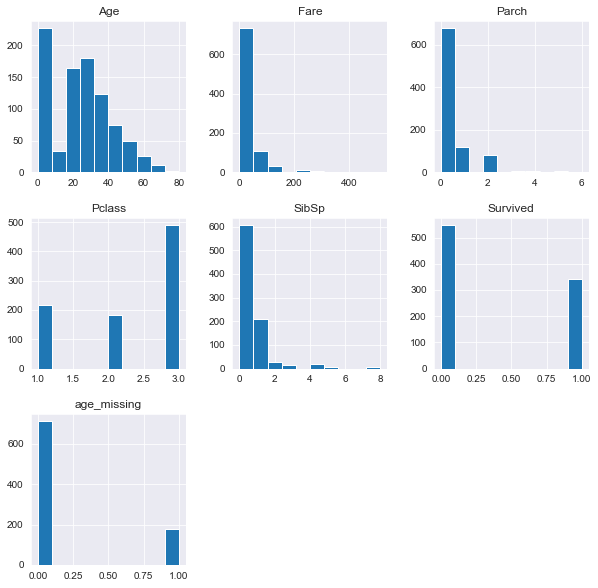

In [55]:
df.hist(figsize=(10, 10))
plt.show()

### Distributions of categorical features

Passengers are more likely to survive if the are female and in a higher class.

Will create is_female binary feature and keep Pclass feature as continuous numerical value.

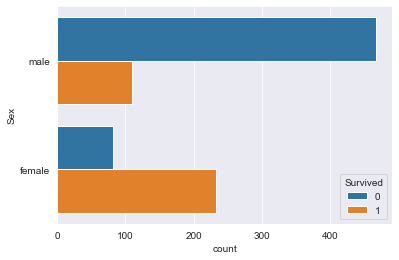

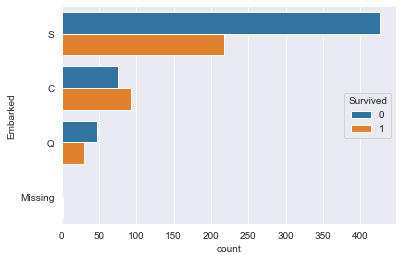

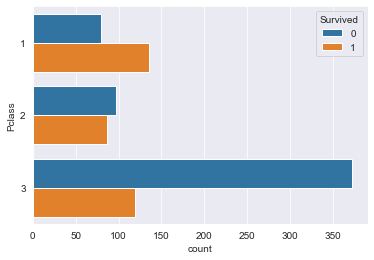

In [56]:
col_list = ['Sex', 'Embarked', 'Pclass']

for col in col_list:
    sns.countplot(y=col, data=df, hue='Survived')
    plt.show()


### Study Correlations
* No strong correlations with target variable
    * Pclass is has some correlation -0.34
* Some correlation exists between Parch and SibSp
    * will consider combining

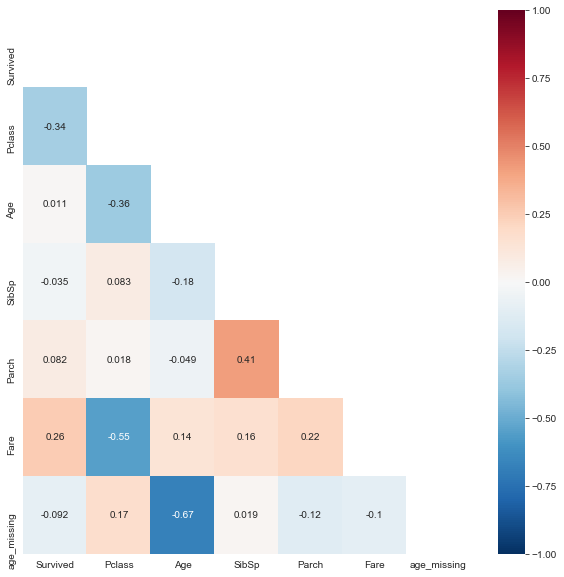

In [59]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

sns.set_style('whitegrid')
plt.figure(figsize=(10,10))

sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            vmax=1,
            vmin=-1           
           )
plt.show()
sns.set_style('darkgrid')

### Avanced Segmentations & Ad-hoc feature engineering

Travel partners
* Duplicate Ticket values likely to be travel partners
* Passengers are more likely to survive if they have a travel partner

Cabin group
* Passengers with cabin more likely to survive than those where value is missing

Married females
* Some passenger names include second name, possibly maiden name
* Married females more likely to survive (do they get extra help? are they pregnant for example? 

Babies and children
* these age groups are more likely to survive

Crew members
* some Fare values are zero
* Could these be crew and likely to go down with the ship?

Family size
* medium size families have a better chance of survival


In [60]:
df['has_travel_partner'] = (
    (df.Ticket.duplicated(keep=False)) |
    ((df.Cabin != 'Missing') & (df.Cabin.duplicated(keep=False))) |
    ((df.Parch + df.SibSp > 0))
).astype(int)


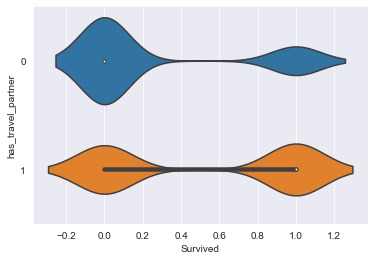

In [61]:
sns.violinplot(x='Survived',
               y='has_travel_partner', 
               data=df,
               orient='h'
              )
plt.show()

In [62]:
df['cabin_group'] = df.Cabin.str.slice(stop=1)

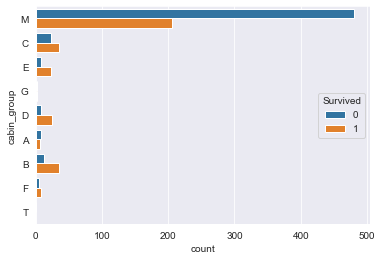

In [63]:
sns.countplot(y='cabin_group', data=df, hue='Survived')
plt.show()

In [64]:
df['second_name'] = df.Name.str.split('(').str[1].str.split(')').str[0]
df.second_name.describe()

count        143
unique       143
top       Marion
freq           1
Name: second_name, dtype: object

In [65]:
df['has_husband'] = (df.second_name.notnull()).astype(int)

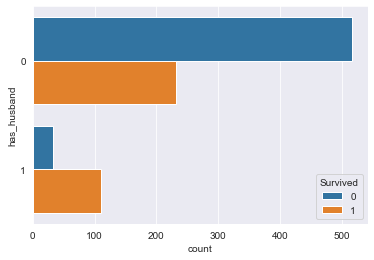

In [66]:
sns.countplot(y='has_husband', data=df, hue='Survived')
plt.show()

In [67]:
df['is_child'] = ((df.Age > 1) & (df.Age < 16)).astype(int)
df[(df.is_child == 1)].Survived.mean()

0.5362318840579711

In [68]:
df['is_baby'] = ((df.Age > 0) & (df.Age < 1)).astype(int)
df[(df.is_baby == 1)].Survived.mean()

1.0

In [69]:
df['is_crew'] = (df.Fare == 0).astype(int)
df[(df.is_crew == 1)].Survived.mean()

0.06666666666666667

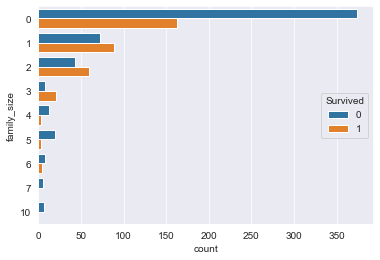

In [70]:
df['family_size'] = df.Parch + df.SibSp

sns.countplot(y='family_size',
              data=df,
              hue='Survived'
             )

plt.show()

In [71]:
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create list of conditions
family_size_conditions = [
(df.Parch + df.SibSp == 0), 
(df.Parch + df.SibSp > 0) & (df.Parch + df.SibSp <=3),
(df.Parch + df.SibSp > 3)
]

# create list of values
family_size_groups = [
    1,
    2,
    3
]

df['family_size_group'] = np.select(family_size_conditions, family_size_groups).astype('object')


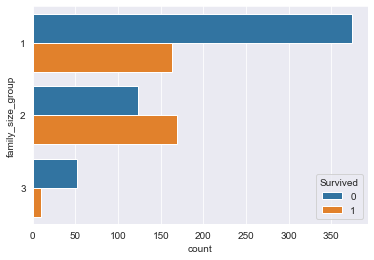

In [72]:
sns.countplot(y='family_size_group',
              data=df,
              hue='Survived'
             )

plt.show()

### More Segmentations

No clear clusters can be found by combining Age and Fare.

Will create groups based on quartiles, and including the following:
* Age == 0 (missing values)
* Age > 0 <= 1 (babies)
* Fare == 0 (potential crew members)

These new groups can replace some binary features created earlier.

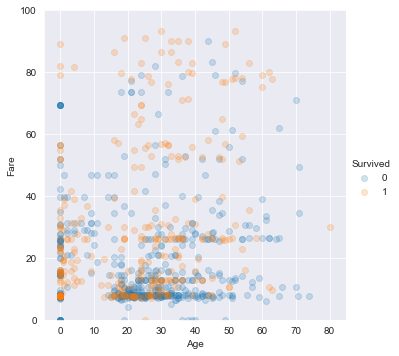

In [73]:
sns.lmplot(x='Age',
           y='Fare',
           hue='Survived',
           data=df,
           fit_reg=False,
           scatter_kws={'alpha':0.2},
           height=5
)

plt.ylim(0, 100)
plt.show()

In [74]:
df[['Age', 'Fare']].describe()

,Age,Fare
count,891.000000,891.000000
mean,23.799293,32.204208
std,17.596074,49.693429
min,0.000000,0.000000
25%,6.000000,7.910400
50%,24.000000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


In [75]:
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# create list of conditions
age_conditions = [
(df.Age == 0), 
(df.Age > 0) & (df.Age <= 1),
(df.Age > 1) & (df.Age <= 24),
(df.Age > 24) & (df.Age <= 35),
(df.Age > 35)
]

# create list of values
age_groups = [
    1,
    2,
    3,
    4,
    5
]

df['age_group'] = np.select(age_conditions, age_groups).astype('object')

In [76]:
# create list of conditions
fare_conditions = [
    (df.Fare == 0),
    (df.Fare > 0) & (df.Fare <= 8),
    (df.Fare > 8) & (df.Fare <= 15),
    (df.Fare > 15) & (df.Fare <= 31),
    (df.Fare > 31)
]

# create list of values
fare_groups = [
    1,
    2,
    3,
    4,
    5
]

df['fare_group'] = np.select(fare_conditions, fare_groups).astype('object')

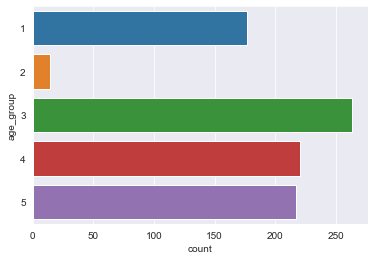

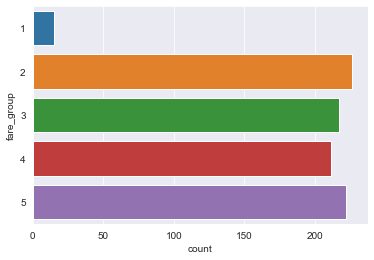

In [77]:
for col in ['age_group', 'fare_group']:
    sns.countplot(y=col, 
                  data=df
                 )
    plt.show()

## Section 4: Data Cleaning

This section will clean the data by

* dropping duplicates
* filling missing values

Although no duplicates were found in train.csv, they may exist in future data sets

In [78]:
def clean_data(df):
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    # fill missing Age values
    df.Age.fillna(0, inplace=True)
    df['age_missing'] = (df.Age == 0).astype(int)
    
    return df  

In [79]:
df = pd.read_csv('train.csv', index_col='PassengerId')
print(df.shape)

(891, 11)


In [80]:
df = clean_data(df)
print(df.shape)

(891, 12)


## Section 5: Feature Engineering

This section will prepare the analytical base table by engineering the features found relevant in from the Exploratory Analyis section.

Some of the original features will be dropped in favour of new ones. This will reduce dimensionality and complexity of the model.

In [83]:
def create_group_features(df):
    
    # age_group
    # create list of conditions
    age_conditions = [
    (df.Age == 0), 
    (df.Age >0) & (df.Age <= 1),
    (df.Age > 1) & (df.Age <= 24),
    (df.Age > 24) & (df.Age <= 35),
    (df.Age > 35)
    ]

    # create list of values
    age_groups = [
        1,
        2,
        3,
        4,
        5
    ]
    
    # create feature as object
    df['age_group'] = np.select(age_conditions, age_groups).astype('object')
    
    # fare_group
    # create list of conditions
    fare_conditions = [
        (df.Fare == 0),
        (df.Fare > 0) & (df.Fare <= 8),
        (df.Fare > 8) & (df.Fare <= 15),
        (df.Fare > 15) & (df.Fare <= 31),
        (df.Fare > 31)
    ]

    # create list of values
    fare_groups = [
        1,
        2,
        3,
        4,
        5
    ]

    df['fare_group'] = np.select(fare_conditions, fare_groups).astype('object')
    
    # family_size_group
    # create list of conditions
    family_size_conditions = [
    (df.Parch + df.SibSp == 0), 
    (df.Parch + df.SibSp > 0) & (df.Parch + df.SibSp <=3),
    (df.Parch + df.SibSp > 3)
    ]

    # create list of values
    family_size_groups = [
        1,
        2,
        3
    ]

    df['family_size_group'] = np.select(family_size_conditions, family_size_groups).astype('object')
    
    return df
    
    

In [84]:
def engineer_features(df):
    
    # binary indicators
    df['has_travel_partner'] = (
        df.Ticket.duplicated(keep=False) | 
        ((df.Cabin != 'Missing') & df.Cabin.duplicated(keep=False)) |
        ((df.Parch + df.SibSp > 0))
        ).astype(int)
    
    df['has_cabin'] = (df.Cabin.notnull()).astype(int)
    
    df['second_name'] = df.Name.str.split('(').str[1].str.split(')').str[0]
    df['has_husband'] = (df.second_name.notnull()).astype(int)
    
    df['is_female'] = (df.Sex == 'female').astype(int)
    
    # interactive features
    df = create_group_features(df)
    
    # get dummies
    df = pd.get_dummies(df, columns=['Embarked', 'age_group', 'fare_group'])
    
    # drop unwanted columns
    col_list = ['Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'second_name']
    df.drop(col_list, axis=1, inplace=True)
    
    return df


In [85]:
df = engineer_features(df)
df.head()


,Survived,Pclass,age_missing,has_travel_partner,has_cabin,has_husband,is_female,family_size_group,Embarked_C,Embarked_Q,...,age_group_1,age_group_2,age_group_3,age_group_4,age_group_5,fare_group_1,fare_group_2,fare_group_3,fare_group_4,fare_group_5
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,1,0,0,0,2,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,1,0,1,1,1,1,2,1,0,...,0,0,0,0,1,0,0,0,0,1
3,1,3,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,1,0,1,1,1,1,2,0,0,...,0,0,0,1,0,0,0,0,0,1
5,0,3,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [86]:
df.to_csv('analytical_base_table.csv')

## Section 6: Algorthim Selection

Since simple linear regression suffers from two major flaws:
1. It's prone to overfit with many input features.
2. It cannot easily express non-linear relationships.

Instead, this section will investigate the application of descision tree ensembles methods. These are
* random forests
* boosted trees


In [87]:
# analytical base table to dataframe
abt = pd.read_csv('analytical_base_table.csv', index_col='PassengerId')
print(abt.shape)
abt.head()

(891, 21)


,Survived,Pclass,age_missing,has_travel_partner,has_cabin,has_husband,is_female,family_size_group,Embarked_C,Embarked_Q,...,age_group_1,age_group_2,age_group_3,age_group_4,age_group_5,fare_group_1,fare_group_2,fare_group_3,fare_group_4,fare_group_5
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,1,0,0,0,2,0,0,...,0,0,1,0,0,0,1,0,0,0
2,1,1,0,1,1,1,1,2,1,0,...,0,0,0,0,1,0,0,0,0,1
3,1,3,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,1,0,1,1,1,1,2,0,0,...,0,0,0,1,0,0,0,0,0,1
5,0,3,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [88]:
# define input and target variables
X = abt.drop('Survived', axis=1)
y = abt.Survived

print('X shape:', X.shape)
print('y shape:', y.shape)   

X shape: (891, 20)
y shape: (891,)


In [89]:
# initialize scaler for X
scaler = StandardScaler()

# fit for and transform X
X_scaled = scaler.fit_transform(X)

# check result
print(X_scaled)

[[ 0.82737724 -0.49789473  0.23598136 ... -0.56741383 -0.5570405
  -0.57605431]
 [-1.56610693 -0.49789473  0.23598136 ... -0.56741383 -0.5570405
   1.73594744]
 [ 0.82737724 -0.49789473  0.23598136 ... -0.56741383 -0.5570405
  -0.57605431]
 ...
 [ 0.82737724  2.0084567   0.23598136 ... -0.56741383  1.79520161
  -0.57605431]
 [-1.56610693 -0.49789473 -4.23762278 ... -0.56741383  1.79520161
  -0.57605431]
 [ 0.82737724 -0.49789473  0.23598136 ... -0.56741383 -0.5570405
  -0.57605431]]


In [90]:
def fit_and_plot_classifier(clf):
    
    # fit
    clf.fit(X_scaled,y)
    
    # predict
    pred = clf.predict_proba(X_scaled)
    pred = [p[1] for p in pred]
    
    # unpack true positive rate and false positive rate for plotting
    fpr, tpr, threshold = roc_curve(y, pred)
    
    # print area under receiver operating characteristic
    print('AUROC:', np.round(roc_auc_score(y_true=y, y_score=pred), 5))
    print()


### Random Forest Experiment

Random forests are strong (unconstrained) models. The parameters to be tuned are
* n_estimators (default 100)
* min_samples_leaf (default 1)

The following results show:
* there are likely no performance gains in adjusting the number of trees (estimators)
* the default min_samples_leaf performs best, although there is a risk of overfitting

In [91]:
for tree in [50, 100, 200]:
    print(tree, 'trees')
    fit_and_plot_classifier(RandomForestClassifier(random_state=123, n_estimators=tree))

50 trees
AUROC: 0.94547

100 trees
AUROC: 0.94547

200 trees
AUROC: 0.9455



In [92]:
for n in [1, 3, 5]:
    print(n, 'min_samples_leaf')
    fit_and_plot_classifier(RandomForestClassifier(random_state=123, min_samples_leaf=n))

1 min_samples_leaf
AUROC: 0.94547

3 min_samples_leaf
AUROC: 0.9124

5 min_samples_leaf
AUROC: 0.90035



### Gradient booster experiment

Gradient boosters are weak (constrained) models. The parameters to be tunes are:
* n_estimators (default 100)
    * Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
* max_depth (default 3)

The following results show:
* increasing the number of trees (estimators) improves the model performance, although risks overfitting
* the performance improves up to a max_depth of 5, then decreases as it gets higher

In [93]:
for trees in [100, 200, 500, 1000]:
    print(trees, 'trees')
    fit_and_plot_classifier(GradientBoostingClassifier(random_state=123, n_estimators=trees))

100 trees
AUROC: 0.91089

200 trees
AUROC: 0.92033

500 trees
AUROC: 0.93381

1000 trees
AUROC: 0.94284



In [94]:
for depth in [1, 3, 5, 7]: 
    print('max_depth:', depth)
    fit_and_plot_classifier(GradientBoostingClassifier(random_state=123, n_estimators=1000, max_depth=depth))

max_depth: 1
AUROC: 0.87394

max_depth: 3
AUROC: 0.94284

max_depth: 5
AUROC: 0.95248

max_depth: 7
AUROC: 0.95248



## Section 7: Model Training

Files train.csv and test.csv have been provided to train and test, however test.csv does not contain the target variable. This file will be treated as the 'new' set of unknowns to predict.

train.csv will be used for model training and selection. This data will be further split into train and test sets in order to compare model performance.

The traing results will show that the GradientBoostingClassifier best estimator scores highest by both the cross validation score and the Area Under the Operating Receiver Statistic (AUROC). This sklearn pipeline will be saved and used to predict the the survival of passengers in the test set.

In [95]:
# training data to dataframe
abt = pd.read_csv('analytical_base_table.csv', index_col='PassengerId')

print(df.shape)

(891, 21)


In [96]:
# define X and y variables
X = abt.drop('Survived', axis=1)
y = abt.Survived

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (891, 20)
y shape: (891,)


In [97]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, stratify=abt.Survived)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (801, 20)
y_train shape: (801,)
X_test shape: (90, 20)
y_test shape: (90,)


In [98]:
# initialize piplines
pipelines = {'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
             'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
            }
pipelines

{'rf': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('randomforestclassifier',
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=100, n_jobs=None,
                                         oob_score=False, random_state=123,
                                         verbose=0, warm_start=False))]

In [99]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_features': ['auto','sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3]
}

In [100]:
# Gradient Boosting hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 500, 1000],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [3, 5, 7]
}

In [101]:
# Hyperparameters dict for easy access
hyperparameters = {
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters
}

In [102]:
# fit, tune, and store fitted models

# empty dict to for storing fitted model
fitted_models = {}

# loop through pipelines
for name, pipeline in pipelines.items():
    
    # create cross validation object
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit model on training data
    model.fit(X_train, y_train)
    
    # store fitted model to dict
    fitted_models[name] = model
    
    # print message
    print(f'{name} model fitted')

rf model fitted
gb model fitted


In [105]:
# evaluate the performance on the training set
for name, model in fitted_models.items():
    print(name, model.best_score_)

rf 0.8189197530864197
gb 0.8276697530864198


In [106]:
# Evaluate performance on the test set - confusion matrix

# loop fitted models test data
for name, model in fitted_models.items():
    
    # get probability score for AUROC input
    pred = model.predict(X_test)

    # print confusion matrix
    cm = confusion_matrix(y_test, pred)
    print(name)
    print(cm)
    print()

rf
[[50  5]
 [12 23]]

gb
[[51  4]
 [12 23]]



rf AUROC: 0.8529870129870128


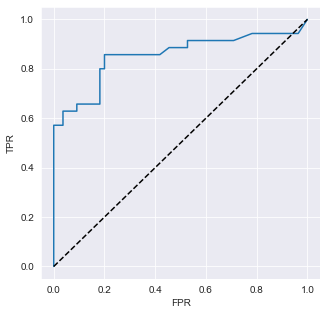

gb AUROC: 0.8748051948051947


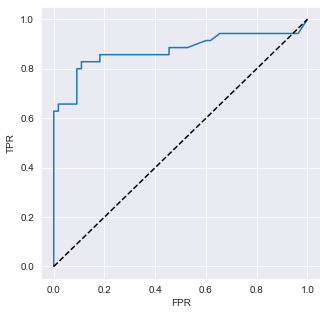

In [107]:
# Evaluate performance on the test set - AUROC (Area Under the Receiving Operating Characteristic)

# loop fitted models test data
for name, model in fitted_models.items():
    
    # get probability score for AUROC input
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    # evaluate prediction using AUROC
    fpr, tpr, threshold = roc_curve(y_test, pred)
    
    # print AUROC score
    print(F'{name} AUROC:', roc_auc_score(np.array(y_test), pred) )
    
    # initialize plot
    plt.figure(figsize=(5,5))
    
    # plot curve
    plt.plot(fpr, tpr)
    
    # plot diagonal line
    plt.plot([0,1],[0,1], 'k--')
    
    #
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [108]:
# Examine the parameters of the best estimator
fitted_models['gb'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.05, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no

In [109]:
# save the best esimator
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

## Insights & Analysis

#### Key findings and results
The Titanic data set was fun to work with. Although it did not contain many features, each feature it did contain provided an opportunity to extract useful information. The data dictionary was useful, however some key questions could not be answered without addition domain knowledge, such as:
* what do the letters in the Ticket column represent?
* why are there so many missing Cabin values?
* what is the definition behind the code of the Cabin values?

The best estimator test AUROC score of 0.856 is not as high as I'd hoped. Since the problem is a competition, I'd hoped to achieve a score of 0.9 or higher before submitting a prediction for the unknowns from test.csv.

Overall, I'm happy with the result as a first attempt. Now that the workflow is in place, further experimenting and testing will be easy to do.

#### Winning model
The winning model was a gradient boosting classifier
* cross validation score 0.827
* AUROC score 0.874

#### What I learned
One thing I learned is to be careful not to spend too much time in the exploratory analysis phase. Unfortunately, I did not have an 'ah-ha' moment, and had to decide when to stop and move on to the next section. I discovered that a high score can be achieved by performing simple cleaning and engineering tasks such as:
1. filling missing values 
2. removing sparse catories
3. creating dummy variables

For example, the GradientBoostingClassifier achieved an equivalent cross-validation score without feature engineering or dimensionality reduction. However, the final model achieved a higher AUROC score.

#### Expanding on this project
Some important next steps will be to examine feature importance with a view to removing irrelevant features and further reducing complexity. In addition, the gradient boosting classifier is known for high performance with extensive tuning. More research into the tuning possibilities would surely help with improving performace. There are also outliers detected in the Fare feature. Since outliers are innocent until proven guilty, additional domain knowledge is needed do determine if some are guilty and how best to replace them.

#### Additional data to aquire
I would like to aquire additional observations to assist with both the Exploratory Analysis and Model Training. The Titanic reportedly had over 3000 people on board including crew, and so the number of observations is relativley low in this current set. Also, Addition features on passenger health would be useful in predicting survival.

### Additional resources

splitting string values
https://datatofish.com/left-right-mid-pandas/

grouping continuous numbers into buckets
https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
